In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
import yfinance as yf 
from yahoo_fin.stock_info import get_data
register_matplotlib_converters()

In [5]:
SP_TSX = get_data("^GSPTSE", 
                  start_date="01/01/2019",
                  end_date="12/15/2020",
                  index_as_date = True,
                  interval="1wk")

#print(SP_TSX.head(10))

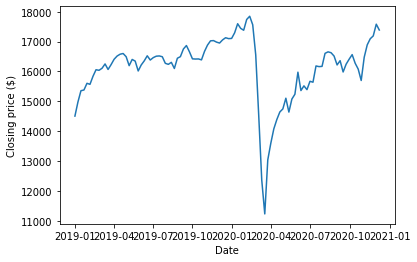

In [13]:
#ARIMA model 
"""
AR <Auto Regressive > means that the model uses the dependent relationship between an observation and somepredefined number of lagged observation
I: < Integrated > means that the model employs differencing of raw observation
MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.

"""
#data 

SP_TSX['date'] = SP_TSX.index

sp_tsx = SP_TSX.reset_index()
sp_tsx = sp_tsx.drop(columns='index')
sp_tsx = sp_tsx[['date', 'open','high','low','close','adjclose', 'volume','ticker']]
sp_tsx = sp_tsx[['date', 'close']]
sp_tsx = sp_tsx.set_index('date')
sp_tsx.head()
plt.xlabel('Date')
plt.ylabel('Closing price ($)')
plt.plot(sp_tsx)

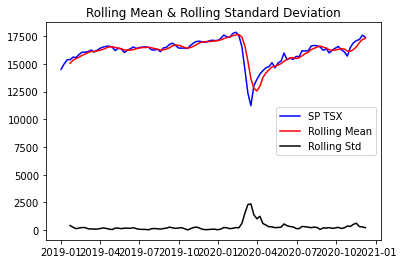

In [25]:
rolling_mean = sp_tsx.rolling(window = 4).mean()
rolling_std = sp_tsx.rolling(window = 4).std()
plt.plot(sp_tsx, color = 'blue', label = 'SP TSX')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

<Figure size 432x288 with 0 Axes>

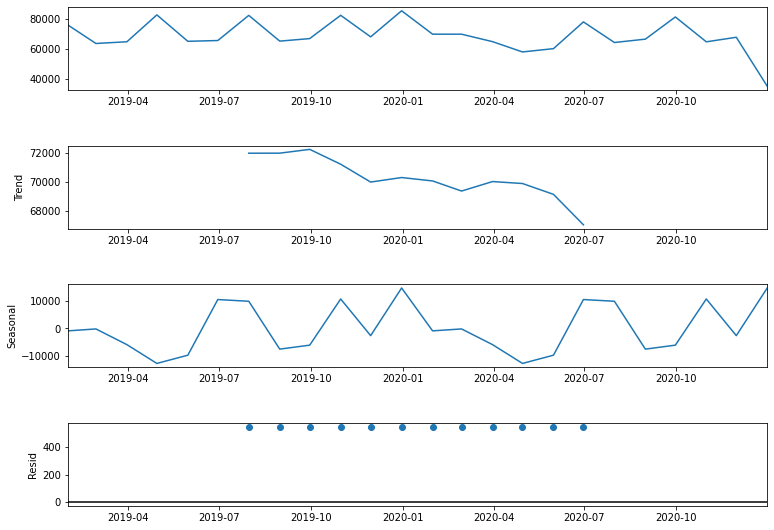

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose  = seasonal_decompose(sp_tsx.resample('M').sum(),freq=12)
fig = plt.figure()
fig = decompose.plot()
fig.set_size_inches(12,8)


In [30]:
#Augmented Dickey-Fuller test in Python (ADF)
"""
The ADF test is an ‘augmented’ version of the Dickey Fuller test. It allows us to determine if our series is stationary or non-stationary.

Now let’s talk main point about Augmented Dickey Fuller Test ( ADF Test ) . This is also used to check stationary of time series. And even we can use to find out the number of differencing used on ARIMA model for forecasting .

The ADF test is a fundamentally a statistical significance test. That means , There is a hypothesis testing involved with a null and alternate hypothesis and as a result a test statistic is computed and p-values get reported. From the statistic test and the p-values , we can make an inference as to whether a given time series is stationary or not.

"""

adf = adfuller(sp_tsx['close'],12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")

"""
The conclusion:
    Our p-value is less then the significance level (0.05), which allow us to rechech the null hypothesis.        This means that our series is stationary. 

In simple word , stationary time series data donot dependent on time. Time series are stationary if they donot have trend or seasonal effects.
"""


Statistics analysis

Statistic Test :  -3.4620051171306843
p-value :  0.009018213503903322
# n_lags :  1
No of observation:  100
 critical value 1% : -3.497501033
 critical value 5% : -2.89090644
 critical value 10% : -2.5824349


'\nThe conclusion:\n    Our p-value is less then the significance level (0.05), which allow us to rechech the null hypothesis.        This means that our series is stationary. \n\nIn simple word , stationary time series data donot dependent on time. Time series are stationary if they donot have trend or seasonal effects.\n'

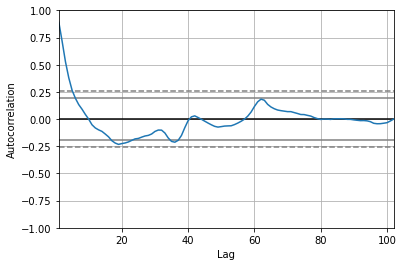

In [93]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sp_tsx['close'])
plt.show()

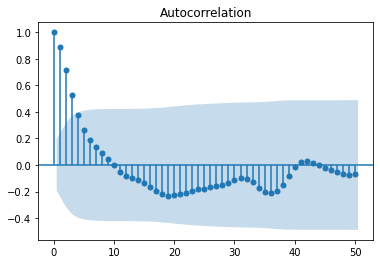

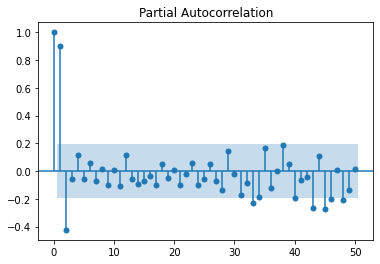

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#allow us toe find the MA term (q), in this case we will go with 2 
plot_acf(sp_tsx, lags=50)
#allow us to find the AR Term (p), in the case the, I'll have to try p= 1 or 2 
plot_pacf(sp_tsx, lags=50)
plt.show()

In [97]:
"""
p = 2 
d = 1 
q = 2

"""

#build the ARIMA Model 

# 2,1,2 Arima Model 

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(sp_tsx.close, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

#This reveal us a lot of infromation:
#The table in the middle is the coeffcients table where the values under 'coef'
# are weights of the respective terms. 

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  101
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -749.804
Method:                       css-mle   S.D. of innovations            404.751
Date:                Sun, 20 Dec 2020   AIC                           1511.609
Time:                        21:15:01   BIC                           1527.299
Sample:                    01-08-2019   HQIC                          1517.961
                         - 12-08-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            28.6967     58.496      0.491      0.624     -85.953     143.347
ar.L1.D.close     0.5053      0.417      1.213      0.225      -0.311       1.322
ar.L2.D.close    -0.4351      0.212     

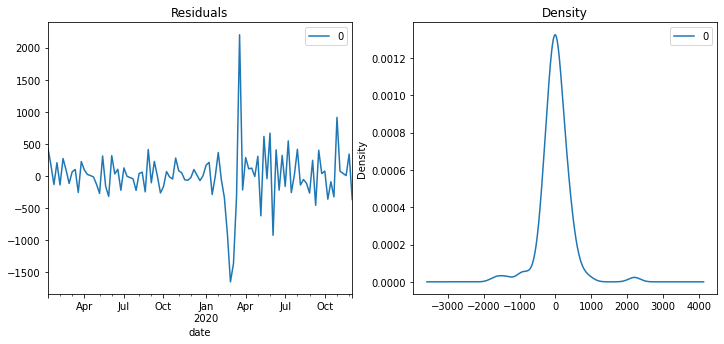

In [103]:
#plot residual errors 
"""
Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).
"""
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
# it looks fine with near zero mean and uniform variance.

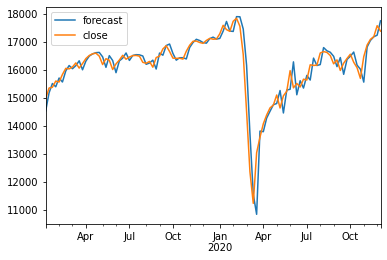

In [104]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#when we see dynamic = false the in-sample lagged values are used for prediction. 
#That is, the model gets trained up until the previous value to make the next prediction. This can make the #fitted forecast and actuals look artificially good.


In [215]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = sp_tsx.close[:57] #[:85]
test = sp_tsx.close[57:] #[85:]


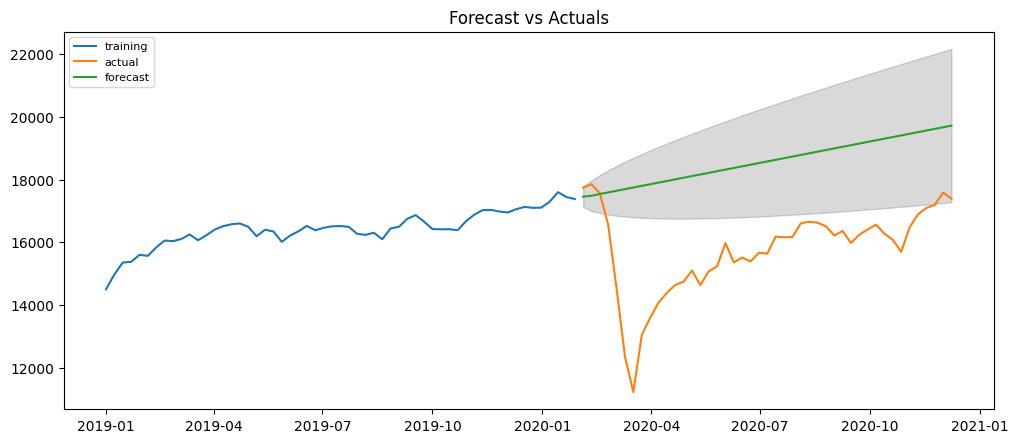

In [210]:
#We can now build our ARIMA model on training dataset, forecast and plot it. 

#Build Model 

#model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3,1,1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [211]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.1884089721463962,
 'me': 2815.586925595127,
 'mae': 2845.478752086323,
 'mpe': 0.18672898987791867,
 'rmse': 3057.7022400239857,
 'acf1': 0.7737401474658141,
 'corr': 0.49709189956671873,
 'minmax': 0.15345680554183838}

The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Lag 1 Autocorrelation of Error (ACF1)
- Correlation between the Actual and the Forecast (corr)
- Min-Max Error (minmax)

In [212]:
#Auto Arima Forecast

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = sp_tsx

smodel = pm.auto_arima(df.close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(smodel.summary())

AttributeError: 'Series' object has no attribute 'close'

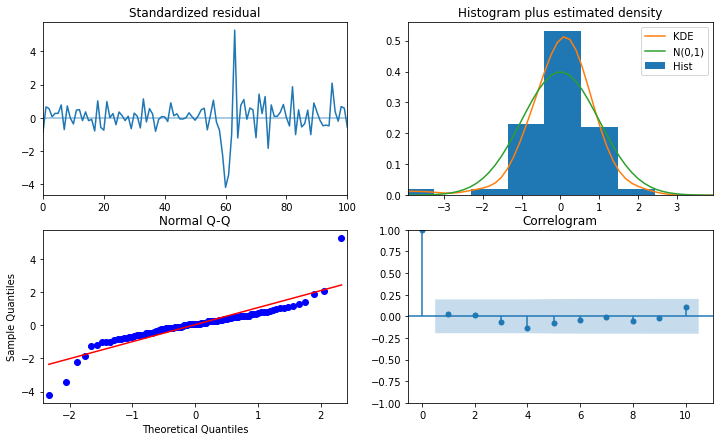

In [185]:
smodel.plot_diagnostics(figsize=(12,7))
plt.show()

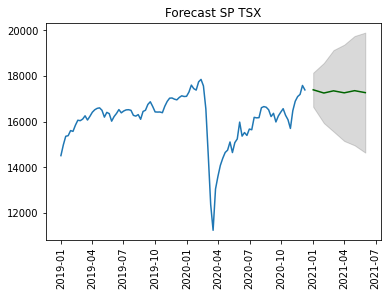

In [178]:
# Forecast
n_periods = 6
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xticks(rotation=90)
plt.title("Forecast SP TSX")
plt.show()